# 1. Training of Surrogate Models

In [1]:
import os
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.optimize import differential_evolution

TRAIN_DIR = "train_data"

X_tr  = np.load(os.path.join(TRAIN_DIR, "X.npy")).astype(float)
yV_tr = np.load(os.path.join(TRAIN_DIR, "y_viscosity.npy")).astype(float)
yE_tr = np.load(os.path.join(TRAIN_DIR, "y_elongation.npy")).astype(float)
yM_tr = np.load(os.path.join(TRAIN_DIR, "y_modulus.npy")).astype(float)
yR_tr = np.load(os.path.join(TRAIN_DIR, "y_reactiontime.npy")).astype(float)

# to fraction
rs = X_tr.sum(axis=1)
if np.allclose(rs, 100.0, atol=1e-6):
    X_tr = X_tr / 10.0
elif np.allclose(rs, 1.0, atol=1e-6):
    X_tr = X_tr * 10.0

# normalization
yV_tr_log = np.log1p(yV_tr)
yE_tr_log = np.log1p(yE_tr)
yM_tr_log = np.log1p(yM_tr)
yR_tr_log = np.log1p(yR_tr)

visc_model = SVR(kernel='rbf', C=100,  gamma=0.1,  epsilon=0.01)
elon_model = SVR(kernel='rbf', C=400,  gamma=0.01, epsilon=0.01)
mod_model  = SVR(kernel='rbf', C=17, gamma=0.04,  epsilon=0.13)
rt_model   = SVR(kernel='rbf', C=68,  gamma=0.03,  epsilon=0.1)

visc_model.fit(X_tr, yV_tr_log)
elon_model.fit(X_tr, yE_tr_log)
mod_model.fit(X_tr, yM_tr_log)
rt_model.fit(X_tr, yR_tr_log);

# 2. Validation of Results

Train metrics (raw R² | log RMSE)
Viscosity     : 1.000 | 0.013
Elongation    : 0.834 | 0.618
Modulus       : 0.969 | 0.304
Reaction Time : 0.880 | 0.145


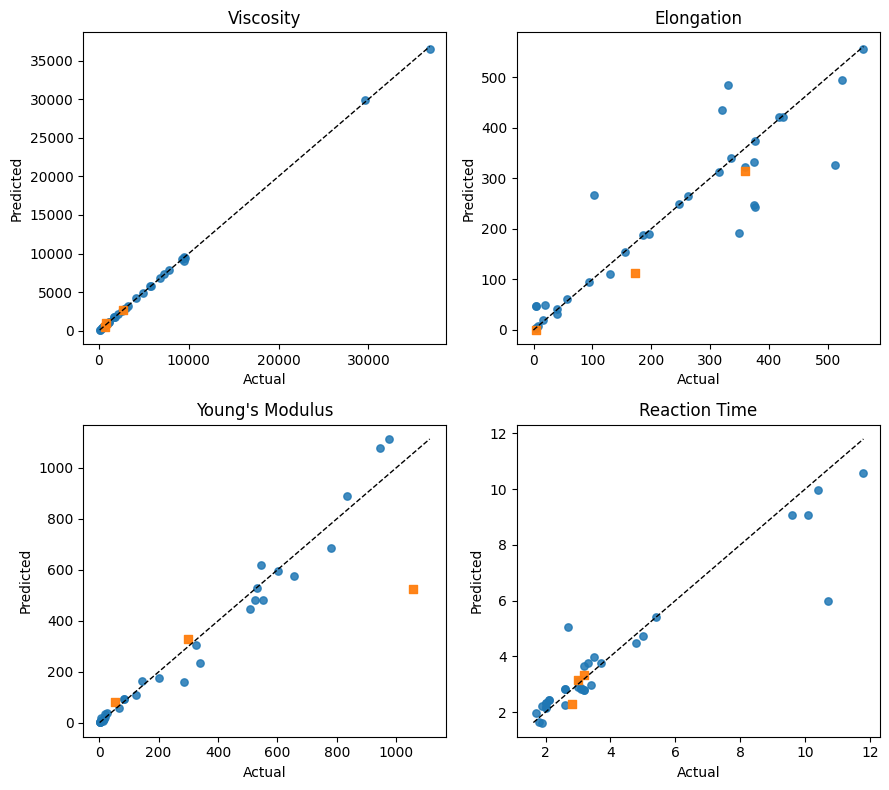

In [2]:
VAL_DIR = "val_data"

X_val  = np.load(os.path.join(VAL_DIR, "X.npy")).astype(float)
yV_val = np.load(os.path.join(VAL_DIR, "y_viscosity.npy")).astype(float)
yE_val = np.load(os.path.join(VAL_DIR, "y_elongation.npy")).astype(float)
yM_val = np.load(os.path.join(VAL_DIR, "y_modulus.npy")).astype(float)
yR_val = np.load(os.path.join(VAL_DIR, "y_reactiontime.npy")).astype(float)

# Normalize val inputs to parts-of-10
rs_val = X_val.sum(axis=1)
if np.allclose(rs_val, 100.0, atol=1e-6):
    X_val = X_val / 10.0
elif np.allclose(rs_val, 1.0, atol=1e-6):
    X_val = X_val * 10.0

# Predictions (train + val), back-transform
yV_hat_tr  = np.expm1(visc_model.predict(X_tr))
yE_hat_tr  = np.expm1(elon_model.predict(X_tr))
yM_hat_tr  = np.expm1(mod_model.predict(X_tr))
yR_hat_tr  = np.expm1(rt_model.predict(X_tr))

yV_hat_val = np.expm1(visc_model.predict(X_val))
yE_hat_val = np.expm1(elon_model.predict(X_val))
yM_hat_val = np.expm1(mod_model.predict(X_val))
yR_hat_val = np.expm1(rt_model.predict(X_val))

print("Train metrics (raw R² | log RMSE)")
print("Viscosity     :", f"{r2_score(yV_tr, yV_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yV_tr), np.log1p(yV_hat_tr)):.3f}")
print("Elongation    :", f"{r2_score(yE_tr, yE_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yE_tr), np.log1p(yE_hat_tr)):.3f}")
print("Modulus       :", f"{r2_score(yM_tr, yM_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yM_tr), np.log1p(yM_hat_tr)):.3f}")
print("Reaction Time :", f"{r2_score(yR_tr, yR_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yR_tr), np.log1p(yR_hat_tr)):.3f}")

# visualization
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
pairs = [
    ("Viscosity",     yV_tr, yV_hat_tr, yV_val, yV_hat_val, axes[0,0]),
    ("Elongation",    yE_tr, yE_hat_tr, yE_val, yE_hat_val, axes[0,1]),
    ("Young's Modulus", yM_tr, yM_hat_tr, yM_val, yM_hat_val, axes[1,0]),
    ("Reaction Time", yR_tr, yR_hat_tr, yR_val, yR_hat_val, axes[1,1]),
]
for title, yt_tr, yp_tr, yt_va, yp_va, ax in pairs:
    lb = float(min(yt_tr.min(), yt_va.min(), yp_tr.min(), yp_va.min()))
    ub = float(max(yt_tr.max(), yt_va.max(), yp_tr.max(), yp_va.max()))
    ax.plot([lb, ub], [lb, ub], "k--", linewidth=1)
    ax.scatter(yt_tr, yp_tr, s=28, alpha=0.85, label="Train")
    ax.scatter(yt_va, yp_va, s=36, alpha=0.95, marker="s", label="Val")
    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
plt.tight_layout()
plt.show()

# 3. Optimization (Differential Evolution)

In [3]:
# objective weights (empirically tuned)
wE, wM, wV, wR = 28.0, 32.0, 0.7, 1.4

# constraints for optimization
bounds = [(4.0, 5.0), (3.0, 5.0), (0.2, 5.0), (0.4, 1.0)]
penalty_weight = 1e6 

objective = lambda x: (
    -(
        wE * np.expm1(elon_model.predict(np.asarray(x, float).reshape(1,-1)).item()) -
        wM * np.expm1(mod_model.predict (np.asarray(x, float).reshape(1,-1)).item()) -
        wV * np.expm1(visc_model.predict(np.asarray(x, float).reshape(1,-1)).item()) -
        wR * np.expm1(rt_model.predict  (np.asarray(x, float).reshape(1,-1)).item())
     )
    + penalty_weight * (np.sum(np.asarray(x, float)) - 10.0)**2
)

result = differential_evolution(
    objective,
    bounds=bounds,
    maxiter=120,
    popsize=20,
    seed=42,
    disp=False,
    polish=True
)

x_best = result.x
print("Optimal parts (PUDA, IBOA, EHMA, MAA):", x_best)

Optimal parts (PUDA, IBOA, EHMA, MAA): [4.99844778 3.         1.60226703 0.4       ]
